## Preprocessing

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import numpy as np
import pandas as pd
import re
import nltk
import math
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive # Uncomment first time running notebook
drive.mount('/content/drive') # Uncomment first time running notebook


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED = 30255

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from nltk.corpus import stopwords
nltk.download('stopwords')

STOPWORDS = set(stopwords.words("english"))

def tokenize(s):
    tokens = [word for word in s.split(" ") if word not in STOPWORDS]
    return tokens

RAW = data.RawField()
TEXT = data.Field(tokenize = tokenize, 
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

SHARED_DRIVE_BASE_FOLDER = "/content/drive/Shareddrives/Advanced ML Project Spring 2021/"

(train_data, valid_data, test_data) = \
  data.TabularDataset.splits(
  path=".\\.data",
  train=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/train_balanced_2001-2019.csv",
  validation=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/validate_balanced_2001-2019.csv",
  test=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/test_balanced_2001-2019.csv",
  format='csv',
  skip_header=True,
  fields=[('id', RAW), ('label', LABEL), ('text', TEXT)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Build the vocab and load the pre-trained word embeddings.

In [ ]:
MAX_VOCAB_SIZE = 5_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

create the iterators

In [ ]:
BATCH_SIZE = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(
  dataset=train_data,
  batch_size = BATCH_SIZE,
  sort_key=lambda x: len(x.review),
  shuffle=True,
  device=device)

valid_iterator = data.BucketIterator(
  dataset=valid_data,
  batch_size = BATCH_SIZE,
  sort_key=lambda x: len(x.review),
  shuffle=True,
  device=device)

test_iterator = data.BucketIterator(
  dataset=test_data,
  batch_size = BATCH_SIZE,
  sort_key=lambda x: len(x.review),
  shuffle=True,
  device=device)

## Build the Model

In our model, we will have different sizes of filters of 3, 4 and 5. Looking for the occurence of different 3-grams, 4-grams and 5-grams that are relevant for analysing "sentiment" of the oral argument. 100 filters of each size.

Then use max pooling on the output of the convolutional layers and apply the activation function.

Then concatenate the 300 filters together into a single vector, apply 50% dropout, and pass them through a linear layer to predict the case outcome.

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = batch size X sent len
        embedded = self.embedding(text)
                
        #embedded = batch size X sent len X emb dim
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = batch size X sent len X emb dim        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = batch size X n_filters X (sent len - filter_sizes[n] + 1)
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = batch size X n_filters
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        #cat = batch size X (n_filters * len(filter_sizes))
        return self.fc(cat)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

See the # of parameters, just for interest.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 620,801 trainable parameters


load the pre-trained embeddings

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.0572, -0.6452, -1.7037,  ..., -0.4365, -0.8213,  0.0095],
        [ 0.8919, -1.0247,  0.9692,  ...,  1.5574, -0.6997, -1.5386],
        [-0.0897, -0.4362,  2.2425,  ...,  0.6206, -0.7791,  0.5458],
        ...,
        [-0.1088, -0.3102, -0.2637,  ...,  0.0434,  0.2978,  0.7851],
        [-0.1198,  0.0747, -0.0700,  ..., -0.2026,  0.2033,  0.0977],
        [ 0.0717, -0.2130, -0.5615,  ..., -0.0854, -0.0518,  0.3673]])

zero the initial weights of the unknown and padding tokens

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=.001)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))

    correct = (rounded_preds == y).float() #convert into float for division 
    
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # to ensure dropout!!
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # to ensure no dropout!!
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.746 | Train Acc: 55.22%
	 Val. Loss: 0.701 |  Val. Acc: 51.19%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.613 | Train Acc: 64.74%
	 Val. Loss: 0.789 |  Val. Acc: 50.00%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.486 | Train Acc: 74.81%
	 Val. Loss: 0.884 |  Val. Acc: 50.00%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.340 | Train Acc: 86.10%
	 Val. Loss: 0.805 |  Val. Acc: 54.76%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
E

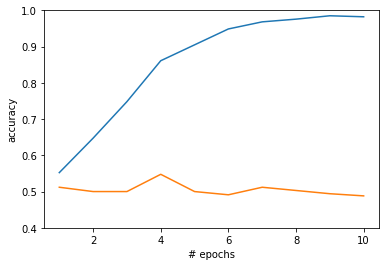

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

training_accuracies = []
validation_accuracies = []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    training_accuracies.append(train_acc)
    validation_accuracies.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

plt.plot(range(1, N_EPOCHS+1), training_accuracies)
plt.plot(range(1, N_EPOCHS+1), validation_accuracies)
plt.xlabel("# epochs")
plt.ylabel("accuracy")
plt.ylim(.4, 1)
plt.show()

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.691 | Test Acc: 55.88%


### GRID SEARCH

In [ ]:
# grid_search = True
grid_search = False

if grid_search:
    N_EPOCHS = 5

    for b_size in [16, 4]:
        for l_rate in [.01, .001, .0001]:
            for opt in [optim.SGD, optim.Adam]:
                for drop in [.2, .5]:
                    for num_filt in [10, 100, 1000]:
                        for max_voc in [1000, 5000, 25000]:
                            RAW = data.RawField()
                            TEXT = data.Field(tokenize = tokenize, 
                                            tokenizer_language = 'en_core_web_sm',
                                            batch_first = True)
                            LABEL = data.LabelField(dtype = torch.float)

                            (train_data, valid_data, test_data) = \
                            data.TabularDataset.splits(
                            # tt.data.TabularDataset.splits(
                            path=".\\.data",
                            # train='train.csv',
                            train=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/train_balanced_2001-2018.csv",
                            # validation='validation.csv',
                            validation=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/validate_balanced_2001-2018.csv",
                            # test='test.csv',
                            test=SHARED_DRIVE_BASE_FOLDER + f"intermediate_data/test_balanced_2001-2018.csv",
                            format='csv',
                            skip_header=True,
                            # fields=[('id', RAW), ('review', TEXT),
                            #   ('label', LABEL)])
                            fields=[('id', RAW), ('label', LABEL), ('text', TEXT)])

                            TEXT.build_vocab(train_data, 
                                            max_size = max_voc, 
                                            vectors = "glove.6B.100d", 
                                            unk_init = torch.Tensor.normal_)

                            LABEL.build_vocab(train_data)

                            train_iterator = data.BucketIterator(
                                            dataset=train_data,
                                            batch_size = b_size,
                                            sort_key=lambda x: len(x.review),
                                            shuffle=True,
                                            device=device)

                            valid_iterator = data.BucketIterator(
                                            dataset=valid_data,
                                            batch_size = b_size,
                                            sort_key=lambda x: len(x.review),
                                            shuffle=True,
                                            device=device)

                            test_iterator = data.BucketIterator(
                                            dataset=test_data,
                                            batch_size = b_size,
                                            sort_key=lambda x: len(x.review),
                                            shuffle=True,
                                            device=device)
                            
                            INPUT_DIM = len(TEXT.vocab)
                            
                            model = CNN1d(INPUT_DIM, 
                                        EMBEDDING_DIM, 
                                        num_filt, 
                                        FILTER_SIZES, 
                                        OUTPUT_DIM, 
                                        drop, 
                                        PAD_IDX)
                            
                            pretrained_embeddings = TEXT.vocab.vectors
                            model.embedding.weight.data.copy_(pretrained_embeddings)

                            UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

                            model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
                            model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

                            optimizer = opt(model.parameters(), lr=l_rate)

                            criterion = nn.BCEWithLogitsLoss()

                            model = model.to(device)
                            criterion = criterion.to(device)

                            best_valid_loss = float('inf')

                            training_accuracies = []
                            validation_accuracies = []
                            for epoch in range(N_EPOCHS):

                                start_time = time.time()
                                
                                train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
                                valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

                                training_accuracies.append(train_acc)
                                validation_accuracies.append(valid_acc)
                                
                                end_time = time.time()

                                epoch_mins, epoch_secs = epoch_time(start_time, end_time)
                                
                                if valid_loss < best_valid_loss:
                                    best_valid_loss = valid_loss
                                    torch.save(model.state_dict(), 'tut4-model.pt')
                                
                                print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
                                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
                                print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
                            
                            plt.plot(range(1, N_EPOCHS+1), training_accuracies)
                            plt.plot(range(1, N_EPOCHS+1), validation_accuracies)
                            plt.ylim(.4, 1)
                            plt.show()

                            model.load_state_dict(torch.load('tut4-model.pt'))

                            test_loss, test_acc = evaluate(model, test_iterator, criterion)

                            print(b_size, l_rate, opt, drop, num_filt, max_voc, ' '.join(map(str,training_accuracies)), ' '.join(map(str,validation_accuracies)), test_acc)
                            print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

### Comparing model performance on a known-to-be-informative dataset

In [ ]:
SEED = 1234 # same random seed for everything

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
TEXT = data.Field(tokenize = tokenize, # same tokenize func
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
MAX_VOCAB_SIZE = 5_000 # same vocab size

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,  # same batch size...despite much larger dataset :/
    device = device)

In [ ]:
model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX) # all same model parameters

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=.001) # same optimizer and LR

criterion = nn.BCEWithLogitsLoss() # same loss function

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
best_valid_loss = float('inf')

training_accuracies = []
validation_accuracies = []
for epoch in range(N_EPOCHS): # same # of epochs

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    training_accuracies.append(train_acc)
    validation_accuracies.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.559 | Train Acc: 70.53%
	 Val. Loss: 0.388 |  Val. Acc: 82.49%
Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.368 | Train Acc: 84.06%
	 Val. Loss: 0.415 |  Val. Acc: 80.81%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.290 | Train Acc: 88.07%
	 Val. Loss: 0.384 |  Val. Acc: 83.79%
Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.224 | Train Acc: 91.07%
	 Val. Loss: 0.406 |  Val. Acc: 83.75%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.175 | Train Acc: 93.44%
	 Val. Loss: 0.486 |  Val. Acc: 83.67%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.142 | Train Acc: 94.79%
	 Val. Loss: 0.561 |  Val. Acc: 83.37%
Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.113 | Train Acc: 95.73%
	 Val. Loss: 0.643 |  Val. Acc: 83.57%
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.102 | Train Acc: 96.30%
	 Val. Loss: 0.780 |  Val. Acc: 82.79%
Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.084 | Train Acc: 97.10%
	 Val. Loss: 0.912 |  Val. Acc: 82.80%
Epoch: 10 | Epoch T

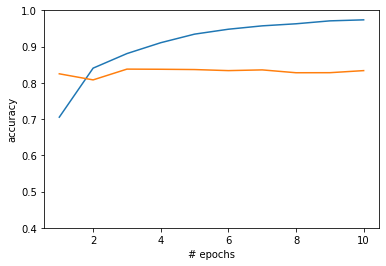

In [ ]:
plt.plot(range(1, N_EPOCHS+1), training_accuracies)
plt.plot(range(1, N_EPOCHS+1), validation_accuracies)
plt.xlabel("# epochs")
plt.ylabel("accuracy")
plt.ylim(.4, 1)
plt.show()

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.379 | Test Acc: 84.26%
